In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate

In [2]:
# Load the dataset
file_path = '/kaggle/input/random/random_user_product_data.csv'
data = pd.read_csv(file_path)

In [3]:
# Step 1: Data Preprocessing and Cleaning
# Convert 'purchase_history' from categorical to numerical (Yes -> 1, No -> 0)
data['purchase_history'] = data['purchase_history'].map({'Yes': 1, 'No': 0})

In [5]:
# Fill missing values using forward fill method
data.ffill(inplace=True)

In [6]:
# Check data after cleaning
print(data.head())

  user_id product_id product_name product_category   price  purchase_history  \
0  user_1  product_1    Product 1        Furniture  229.52                 1   
1  user_2  product_2    Product 2        Groceries  274.96                 0   
2  user_3  product_3    Product 3         Clothing  397.00                 0   
3  user_4  product_4    Product 4         Clothing  336.80                 1   
4  user_5  product_5    Product 5        Groceries  375.44                 1   

   user_clicks  ratings  
0           16      4.2  
1           45      4.0  
2            6      1.3  
3           62      4.5  
4           67      1.2  


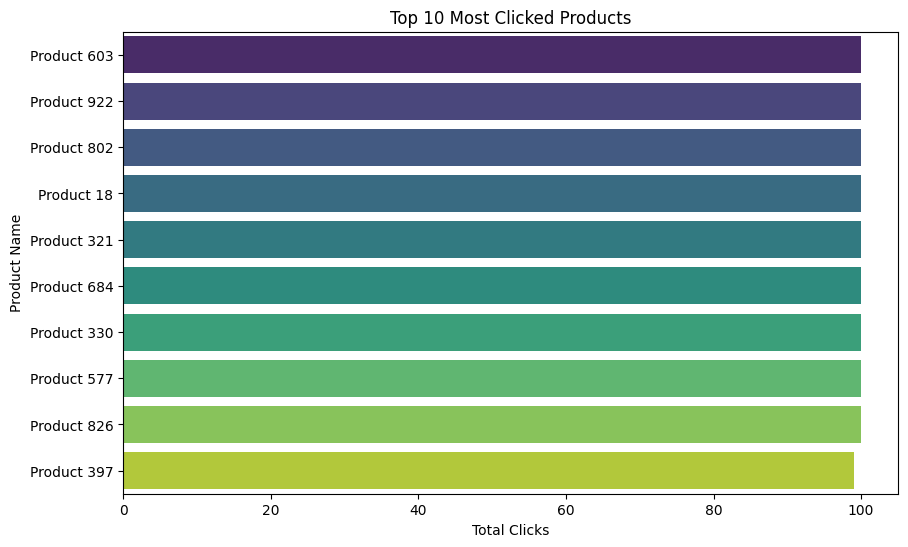

In [7]:
# Step 2: Exploratory Data Analysis (EDA)
# Popular products based on user clicks
plt.figure(figsize=(10, 6))
top_products = data.groupby('product_name')['user_clicks'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Clicked Products')
plt.xlabel('Total Clicks')
plt.ylabel('Product Name')
plt.show()

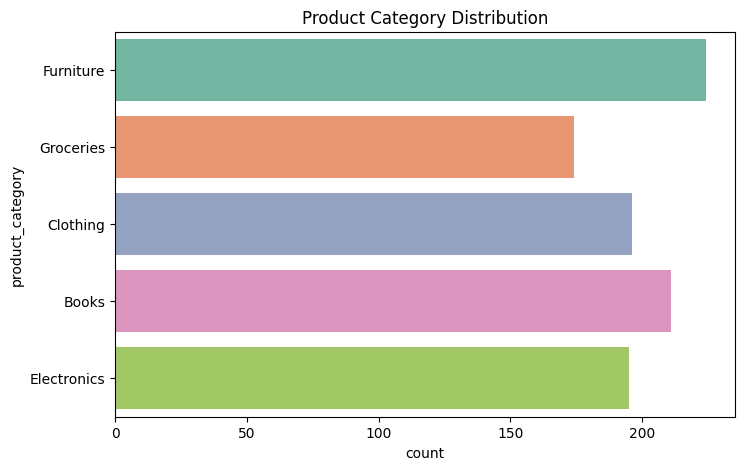

In [8]:
# Distribution of product categories
plt.figure(figsize=(8, 5))
sns.countplot(y='product_category', data=data, palette='Set2')
plt.title('Product Category Distribution')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


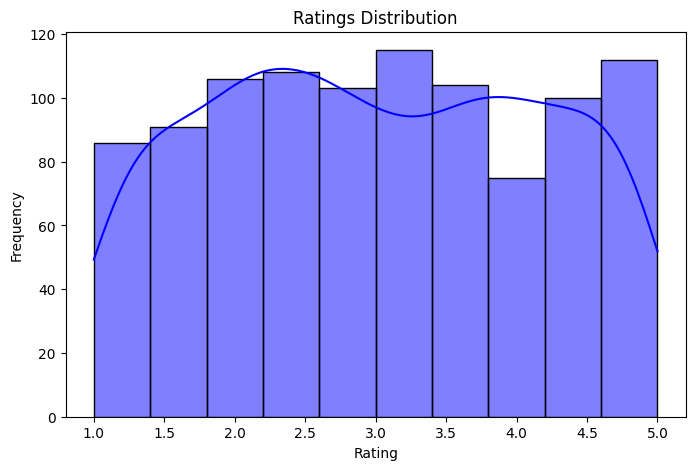

In [11]:
# Ratings distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['ratings'], bins=10, kde=True, color='blue')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Step 3: Build Recommendation System
# We'll use a collaborative filtering approach (Matrix Factorization using SVD)

# Select only relevant columns for recommendation system
recommendation_data = data[['user_id', 'product_id', 'ratings']]


In [13]:
# Step 4: Prepare Data for Collaborative Filtering using Surprise Library
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(recommendation_data, reader)

In [14]:
# Train-test split
trainset = surprise_data.build_full_trainset()

In [15]:
# Step 5: Train Collaborative Filtering Model (SVD)
model = SVD()

In [17]:
# Train the model
model.fit(trainset)

In [18]:
# Step 6: Evaluate the Model
cross_validate(model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1109  1.1057  1.1670  1.1552  1.2253  1.1528  0.0434  
MAE (testset)     0.9583  0.9434  1.0030  1.0050  1.0867  0.9993  0.0500  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.11092889, 1.1057439 , 1.16698249, 1.15524005, 1.22532716]),
 'test_mae': array([0.95826   , 0.9433675 , 1.00297875, 1.005     , 1.0866725 ]),
 'fit_time': (0.017958641052246094,
  0.01598811149597168,
  0.01655888557434082,
  0.016304492950439453,
  0.016553401947021484),
 'test_time': (0.0013797283172607422,
  0.0013165473937988281,
  0.0012423992156982422,
  0.0012464523315429688,
  0.0012631416320800781)}

In [19]:
# Step 7: Make Recommendations for a specific user (example: user_id='user_1')
user_id = 'user_1'
user_rated_products = recommendation_data[recommendation_data['user_id'] == user_id]['product_id'].tolist()


In [20]:
# Predict ratings for all products the user has not rated
product_ids = data['product_id'].unique()


In [21]:
# Predict ratings for all products the user has not rated
product_ids = data['product_id'].unique()


In [22]:
# Filter out products already rated by the user
recommendable_products = [pid for pid in product_ids if pid not in user_rated_products]

In [23]:
# Generate predictions for unrated products
predictions = [model.predict(user_id, product_id).est for product_id in recommendable_products]

In [24]:
# Sort products by predicted rating
recommended_products = pd.DataFrame({
    'product_id': recommendable_products,
    'predicted_rating': predictions
}).sort_values(by='predicted_rating', ascending=False).head(10)

In [25]:
print("Top 10 Recommended Products for User {}: ".format(user_id))
print(recommended_products)

Top 10 Recommended Products for User user_1: 
      product_id  predicted_rating
615  product_617          3.474045
680  product_682          3.461476
534  product_536          3.455681
768  product_770          3.438532
369  product_371          3.430467
655  product_657          3.426542
554  product_556          3.412318
253  product_255          3.407409
416  product_418          3.406670
922  product_924          3.404864


In [26]:
# Display product details for the recommended products
recommended_product_details = data[data['product_id'].isin(recommended_products['product_id'])]
print(recommended_product_details)

      user_id   product_id product_name product_category   price  \
254  user_255  product_255  Product 255         Clothing  320.05   
370  user_371  product_371  Product 371         Clothing  280.69   
417  user_418  product_418  Product 418        Furniture   28.93   
535  user_536  product_536  Product 536        Groceries  437.90   
555  user_556  product_556  Product 556      Electronics   34.57   
616  user_617  product_617  Product 617         Clothing  264.37   
656  user_657  product_657  Product 657        Furniture  237.87   
681  user_682  product_682  Product 682      Electronics  470.84   
769  user_770  product_770  Product 770        Furniture  131.94   
923  user_924  product_924  Product 924        Furniture  316.75   

     purchase_history  user_clicks  ratings  
254                 0           44      4.8  
370                 1           92      5.0  
417                 1           18      4.8  
535                 1           92      5.0  
555                 0